https://stackoverflow.com/questions/63581359/how-to-fit-multiple-exponential-curves-using-python/63594528?noredirect=1#comment112500327_63594528

Split dataset using first derivative criterion (the first difference is highly positive when curve change) then apply single curve fit either by shifting to origin or adding an extra lag parameter. Finally assemble results.
_____________________________________________________________________________________________________________________
The problem can easily be tackled by splitting the dataset using a simple criterion such as first derivative estimate and then we can apply simple curve fitting procedure to each sub dataset.

https://en.wikipedia.org/wiki/Derivative_test

## Trial Dataset

First, let's import some packages and create a synthetic dataset with three curves to represent your problem.

We use a two parameters exponential model as time origin shift will be handled by t

In [2]:
import numpy as np
import pandas as pd
from scipy import signal, optimize
import matplotlib.pyplot as plt

In [3]:
def func(x,a,b):
    return a*np.exp(b*x)

In [4]:
N = 1001
n1 = N//3 #333
n2 = 2*n1 #666

In [5]:
t = np.linspace(0,10,N)

In [6]:
x0 = func(t[:n1], 1, -0.2)
x1 = func(t[n1:n2]-t[n1], 5, -0.4)
x2 = func(t[n2:]-t[n2], 2, -1.2)

In [7]:
x = np.hstack([x0, x1, x2])
xr = x + 0.025*np.random.randn(x.size)

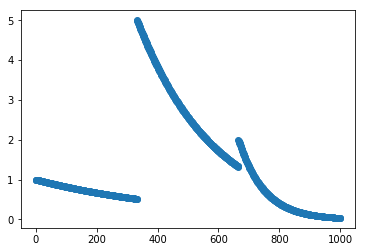

In [8]:
plt.plot(x, 'o')

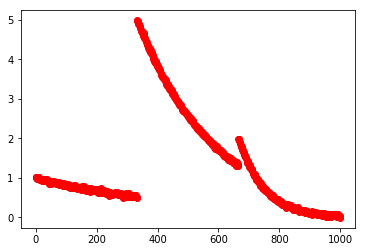

In [9]:
plt.plot(xr, 'ro')

In [10]:
x == xr

array([False, False, False, ..., False, False, False])

## Graphically, it renders as follows:

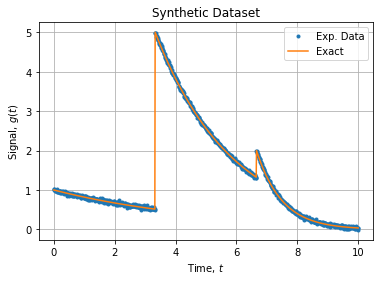

In [11]:
fig, axe = plt.subplots()
axe.plot(t, xr, '.', label='Exp. Data')
axe.plot(t, x, '-', label='Exact')
axe.set_title("Synthetic Dataset")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Signal, $g(t)$")
axe.legend()
axe.grid()

## Dataset Splitting
We can split the dataset into three sub-datasets using a simple criterion as first derivative estimate using first difference to assess it. The goal is to detect when curve drastically goes up or down (where dataset should be split. First derivative is estimated as follow):

In [13]:
dxrdt = np.abs(np.diff(xr)/np.diff(t))

The criterion requires an extra parameter (threshold) that must be tuned accordingly to your signal specifications. The criterion is equivalent to:

In [14]:
xcrit = 20
q = np.where(dxrdt > xcrit)
q

(array([332, 665], dtype=int64),)

And split index are:

In [15]:
idx = [0] + list(q[0]+1) + [t.size]
idx

[0, 333, 666, 1001]

Mainly the criterion threshold will be affected by the nature and the power of the noise on your data and the gap magnitudes between two curves. The usage of this methodology depends on the ability to detect curves gap in presence of noise. It will break when the noise power has the same magnitude of the gap we want to detect. You can also observe false split index if the noise is heavily tailed (few strong outliers).

In this MCVE, we have set the threshold to 20 [Signal Units/Time Units]:

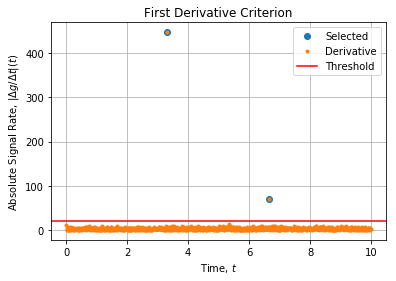

In [65]:
fig, axe = plt.subplots()
axe.plot(t[q[0]], dxrdt[q[0]], 'o', label='Selected')
axe.plot(t[:-1], dxrdt, '.', label='Derivative')
axe.axhline(xcrit, color="red", label='Threshold')
axe.set_title("First Derivative Criterion")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Absolute Signal Rate, $|\Delta g/\Delta t|(t)$")
axe.legend()
axe.grid()

An alternative to this hand-crafted criterion is to delegate the identification to the excellent find_peaks method of scipy. But it will not avoid the requirement to tune the detection to your signal specifications.

## Fit origin-shifted dataset
Now we can apply the curve fitting on each sub-dataset (with origin shifted time), collect parameters and statistics and plot the result:

## Graphically we can check the goodness of fits:

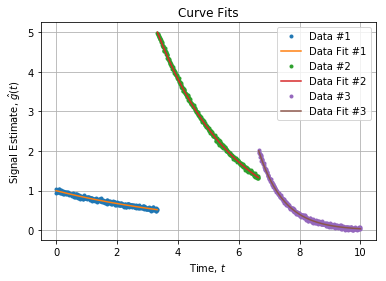

In [66]:
trials = []
fig, axe = plt.subplots()
for k, (i, j) in enumerate(zip(idx[:-1], idx[1:])):
    p, s = optimize.curve_fit(func, t[i:j]-t[i], xr[i:j])
    axe.plot(t[i:j], xr[i:j], '.', label="Data #{}".format(k+1))
    axe.plot(t[i:j], func(t[i:j]-t[i], *p), label="Data Fit #{}".format(k+1))
    trials.append({"n0": i, "n1": j, "t0": t[i], "a": p[0], "b": p[1],
                   "s_a": s[0,0], "s_b": s[1,1], "s_ab": s[0,1]})
axe.set_title("Curve Fits")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Signal Estimate, $\hat{g}(t)$")
axe.legend()
axe.grid()

It returns the following fitting results:

In [71]:
df

,a,b,n0,n1,s_a,s_ab,s_b,t0
0,0.997438,-0.197147,0,333,0.000009,-0.000005,3.725809e-06,0.00
1,4.994634,-0.399165,333,666,0.000012,-0.000001,2.976536e-07,3.33
2,2.000956,-1.202175,666,1001,0.000030,-0.000018,2.210951e-05,6.66


In [72]:
print(df)

          a         b   n0    n1       s_a      s_ab           s_b    t0
0  0.997438 -0.197147    0   333  0.000009 -0.000005  3.725809e-06  0.00
1  4.994634 -0.399165  333   666  0.000012 -0.000001  2.976536e-07  3.33
2  2.000956 -1.202175  666  1001  0.000030 -0.000018  2.210951e-05  6.66


Which complies with our original parameters (see Trial dataset section).

## End

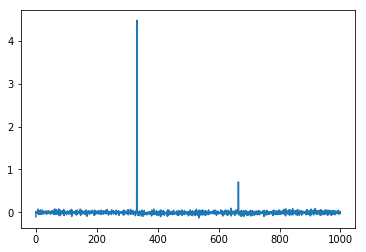

In [43]:
plt.plot(np.diff(xr))

In [59]:
idx

[0, 333, 666, 1001]

In [64]:
q[0]+1

array([333, 666], dtype=int64)

In [70]:
df = pd.DataFrame(trials)

In [77]:
idx[:-1]

[0, 333, 666]

In [78]:
idx[1:]

[333, 666, 1001]

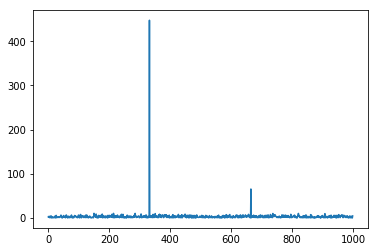

In [17]:
plt.plot(dxrdt)

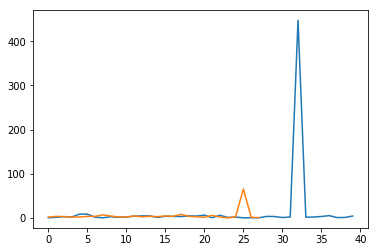

In [23]:
plt.plot(dxrdt[300:340])
plt.plot(dxrdt[640:680])

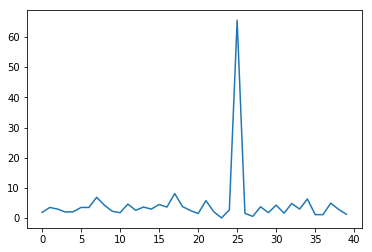

In [27]:
plt.plot(dxrdt[640:680])


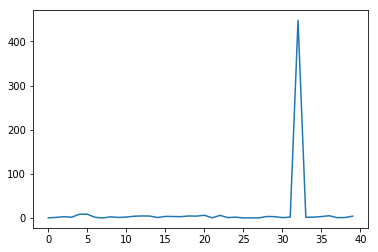

In [25]:
plt.plot(dxrdt[300:340])